# PyTorch

We will use [PyTorch](https://pytorch.org) in the rest of the lecture. This will allow 
- faster execution of our models (since pytorch code is better optimized than our tensor class)
- usage of pre-made functionality and convenience, but we will strive to implement as much as possible ourselves.

In [67]:
# possibly install pytorch via
# 1) conda install pytorch torchvision -c pytorch
# or 2) pip install torch torchvision 
import math
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)


mps


In [41]:
# import Fashion-MNIST
import sys
import os

# Add the path to the utils directory
fashion_mnist_path = os.path.join(os.getcwd(), 'fashion-mnist')
sys.path.append(fashion_mnist_path)

from utils import mnist_reader

X_train, y_train = mnist_reader.load_mnist(os.path.join(fashion_mnist_path, 'data/fashion'), kind='train')
X_test, y_test = mnist_reader.load_mnist(os.path.join(fashion_mnist_path, 'data/fashion'), kind='t10k')

In [42]:
# Normalize the input data:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
X_train /= 255.0
X_test /= 255.0

## CNN in PyTorch

We will reimplement the CNN written using out tensor class in the notebook before in pytorch.

### PyTorch goodies & boilerplate

- Each pytorch module subclasses from `nn.Module` and must invoke the parent constructor via `super(${class name}, self).__init__()`. This
  - automatically registers all parameters that are to be updated accessible via `parameters()`
  - gives access to functions `state_dict()`, a dictionary for the model's state, `eval()` and `train()` to set the module into evaluation or training mode.
  - allows integration to pytorch ecosystem, including optimizers, loss functions ... (not all used here)
- `forward` is the pytorch equivalent to the `__call__` dunder used in our previous NNs.
- `nn.Sequential` collects a number of modules and calls them in sequence.


In [29]:
class CNN(nn.Module):
    def __init__(self, c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2):
        super(CNN, self).__init__()

        self.ops = []
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
        )

        self.MLP = nn.Sequential(
            nn.Flatten(start_dim=-3, end_dim=-1),
            nn.Linear(in_features=7*7*hidden_dim_2, out_features=c_out),
            # nn.Softmax() -> no softmax, cross entropy loss in pytorch already applies softmax
        )
            
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.MLP(x)
        return x

In [36]:
# Initialize weights

def uniform_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data.uniform_(-0.1, 0.1)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
#    if isinstance(m, nn.Conv2d):
#        init.kaiming_normal_(m.weight, nonlinearity='relu')
#        if m.bias is not None:
#            init.constant_(m.bias, 0)
#    elif isinstance(m, nn.Linear):
#        init.kaiming_normal_(m.weight, nonlinearity='relu')
#        init.constant_(m.bias, 0)

### Softmax?

Attention: cross-entropy in python implicitly applies softmax to the scores. If you returned softmax probabilities, softmax would be applied twice. You must stick with scores!

### Pytorch dimension convention for images

`B x C x H x W`
- `B` is the batch size (without batch can have first dimension 1)
- `C` is the number of channels/features
- `H` and `W`: height and width of images

When using a pytorch function, e.g. a 2d-convolution, the function is applied to all elements in the batch independently.
By using one tensor for holding a whole batch we can increase parallelism and performance.

## Pytorch tensor

The pytorch tensor class functions similarly as our previous one. It holds a multi-dimensional tensor and has pointers for building a computational graph and holding eventual gradients.


### Device usage

In contrast to our `Tensor` class, we can store the tensor and execute computations on other devices. In our case, the `cpu`, a possible GPU programmed via `cuda` or Apple shaders addressed through `mps` are options.

In order to transfer a tensor to a device we have to call `to(device)`, where `device` holds a string denoting where the tensor should go. In a computation, all tensors must be on the same device.

In [37]:
# Test CNN
x = torch.randn(1, 28, 28).to(device)
model = CNN(c_in=1, c_out=10, hidden_dim_1 = 4, hidden_dim_2 = 8).to(device)
model.apply(uniform_init)
print(model(x))

tensor([ 8.9436e-03,  1.5392e-02,  8.6919e-05, -3.6592e-03,  4.3432e-03,
        -3.4158e-03, -8.1936e-04,  5.1128e-03, -4.0604e-03,  1.5982e-03],
       device='mps:0', grad_fn=<LinearBackward0>)


In [38]:
# return dictionary of all model modules and their values
model.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.0119,  0.0387,  0.0126],
                        [ 0.0769, -0.0252,  0.0428],
                        [-0.0470, -0.0915,  0.0122]]],
              
              
                      [[[ 0.0092,  0.0201,  0.0124],
                        [-0.0384,  0.0509, -0.0239],
                        [ 0.0415,  0.0883, -0.0107]]],
              
              
                      [[[-0.0201,  0.0139,  0.0322],
                        [-0.0981,  0.0426, -0.0701],
                        [ 0.0544,  0.0185, -0.0421]]],
              
              
                      [[[ 0.0036, -0.0870,  0.0738],
                        [ 0.0689, -0.0383,  0.0004],
                        [-0.0165, -0.0745,  0.0555]]]], device='mps:0')),
             ('conv_block_1.0.bias', tensor([0., 0., 0., 0.], device='mps:0')),
             ('conv_block_1.2.weight',
              tensor([[[[ 0.0874, -0.0131, -0.0334],
                        [ 0.0573, -0

In [39]:
# count number of parameters
sum(p.numel() for p in model.parameters())

4998

For validation we do not need to keep intermediate activations which are necessary for backprop. We can execute NNs in pytorch faster by allowing it to throw away everything needed for backprop by setting `model.eval()` and switch back to `model.train()` when we resume training.

In [43]:
def validate(model, X_val, y_val):
    # store model mode and set back to original mode after validation
    model_mode = model.training
    model.eval()
    correct_predictions = 0
    
    batch_size = 128
    with torch.no_grad(): # do not record gradients
        for i in range(0,X_val.shape[0],batch_size):
            x = torch.Tensor(X_val[i:i+batch_size]).to(device)
            x = x.reshape(-1, 1, 28, 28)
            y_true = y_val[i:i+batch_size]
            
            # Forward pass
            y_pred = model(x)
            
            # Get the predicted class (assuming y_pred is a Tensor with probabilities)
            predicted_class = torch.argmax(y_pred.data, dim=1)
            
            # Check if the prediction is correct
            correct_predictions += (predicted_class.cpu().numpy() == y_true).sum()
            
    
    # Calculate accuracy
    accuracy = correct_predictions / X_val.shape[0]
    model.train(model_mode)
    return accuracy

In [47]:
# Test validation
val_acc = validate(model, X_val=X_test, y_val=y_test)
print(val_acc)

0.8495


In [45]:
def train(model, num_epochs=3, lr=0.1):
    model.train()
    val_acc = validate(model, X_test, y_test)
    train_acc = validate(model, X_train, y_train)
    print(f"Before training: validation accuracy: {val_acc}")

    # Parameters
    batch_size = 32

    # Training loop
    losses = []
    val_accs = []
    train_accs = []

    for epoch in range(num_epochs):
        # Shuffle the data at the beginning of each epoch
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        loss = 0.0
        
        for i in range(0, X_shuffled.shape[0], batch_size):
            X_batch = torch.Tensor(X_shuffled[i:i + batch_size]).to(device)
            X_batch = X_batch.reshape(-1,1,28,28)
            y_batch = torch.Tensor(y_shuffled[i:i + batch_size]).to(device)
        
            # Forward pass
            preds = model(X_batch)
            
            # Loss calculation
            mb_loss = mb_loss = F.cross_entropy(preds, target=y_batch)
            loss += mb_loss * X_batch.shape[0] / X_train.shape[0]

            #for layer in model.modules():
            #    layer.out.retain_grad() ### Just temproary
            
            ### ZERO GRAD ###
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.zero_()

            # backward pass
            mb_loss.backward()
        
            # The weight update
            for p in model.parameters():
                p.data += -lr * p.grad

        losses.append(loss)
        val_acc = validate(model, X_test, y_test)
        val_accs.append(val_acc)
        train_acc = validate(model, X_train, y_train)
        train_accs.append(train_acc)
        print(f"Epoch {epoch}, Loss: {loss}, validation accuracy: {val_acc}, train accuracy: {train_acc}")

    return losses, val_accs, train_accs

In [ ]:
model = CNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8).to(device)
model.apply(uniform_init)
train(model)

Before training: validation accuracy: 0.1
Epoch 0, Loss: 0.7118512988090515, validation accuracy: 0.8511, train accuracy: 0.8644833333333334
Epoch 1, Loss: 0.37532860040664673, validation accuracy: 0.8671, train accuracy: 0.8806333333333334
Epoch 2, Loss: 0.3408384919166565, validation accuracy: 0.8495, train accuracy: 0.8637833333333333


([tensor(0.7119, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.3753, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.3408, device='mps:0', grad_fn=<AddBackward0>)],
 [0.8511, 0.8671, 0.8495],
 [0.8644833333333334, 0.8806333333333334, 0.8637833333333333])

The network runs much faster now. This is accomplished through
- faster implementation of pytorch
- working using an accelerator (here MPS from Apple, but more typically CUDA when using GPUs)

# Deeper Model

Let us make the model more powerful by adding more convolutional layers.

In [48]:
class DeeperCNN(nn.Module):
    def __init__(self, c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.ReLU):
        super(DeeperCNN, self).__init__()

        self.ops = []
        self.conv_block_1 = [
            nn.Conv2d(in_channels=c_in, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            activation(),
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_1.extend([
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            activation()
            ])
        self.conv_block_1.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.conv_block_1 = nn.Sequential(*self.conv_block_1)

        self.conv_block_2 = [
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            activation()
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_2.extend([
            nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            activation()
            ])
        self.conv_block_2.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.conv_block_2 = nn.Sequential(*self.conv_block_2)

        self.MLP = nn.Sequential(
            nn.Flatten(start_dim=-3, end_dim=-1),
            nn.Linear(in_features=7*7*hidden_dim_2, out_features=c_out),
            # nn.Softmax() -> no softmax, cross entropy loss in pytorch already applies softmax
        )
            
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.MLP(x)
        return x

In [49]:
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1 = 4, hidden_dim_2=8, nr_convs_per_block=4).to(device)
model.apply(uniform_init)
print(f"Number of parameters of deeper model = {sum(p.numel() for p in model.parameters())}")
train(model, num_epochs=2)

Number of parameters of deeper model = 6462
Before training: validation accuracy: 0.1172
Epoch 0, Loss: 2.3033721446990967, validation accuracy: 0.1, train accuracy: 0.1
Epoch 1, Loss: 2.3033621311187744, validation accuracy: 0.1, train accuracy: 0.1


([tensor(2.3034, device='mps:0', grad_fn=<AddBackward0>),
  tensor(2.3034, device='mps:0', grad_fn=<AddBackward0>)],
 [0.1, 0.1],
 [0.1, 0.1])

## Problems

Training the deeper CNN is not working. 
We have added more parameters to the model. Therefore, it should be better able to fit the loss and obtain a lower loss ultimately.
What happens however is that it makes no progress during training at all.

One culprit could be the training algorithm, i.e. gradient descent not working well.
Let us inspect how the gradients are doing.

## Activation statistics

In [78]:
# Function to capture activations
def visualize_activations(model, x):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Test CNN
    #model = CNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2).to(device)

    # Register hooks to capture activations
    for name, layer in model.named_modules():
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU):
            layer.register_forward_hook(get_activation(name))

    # Forward pass
    output = model(x)

    # Plot activations
    plt.figure(figsize=(20, 6))
    legends = []
    for name, activation in activations.items():
        print(f"Layer[{name}] — mean: {activation.mean():.2f}\tstd: {activation.std():.2f}\tsaturation: {(activation.abs() > 0.01).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(activation, density=True)
        plt.plot(hx[:-1].detach().to('cpu').numpy(), hy.detach().to('cpu').numpy())
        legends.append(f"Layer[{name}] ReLU")
    plt.legend(legends)
    plt.title("After activation per layer", fontsize=20)
    plt.show()

Layer[conv_block_1.1] — mean: 0.07	std: 0.11	saturation: 47.29%
Layer[conv_block_1.3] — mean: 0.01	std: 0.02	saturation: 28.83%
Layer[conv_block_1.5] — mean: 0.00	std: 0.01	saturation: 10.94%
Layer[conv_block_1.7] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.1] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.3] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.5] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.7] — mean: 0.00	std: 0.00	saturation: 0.00%


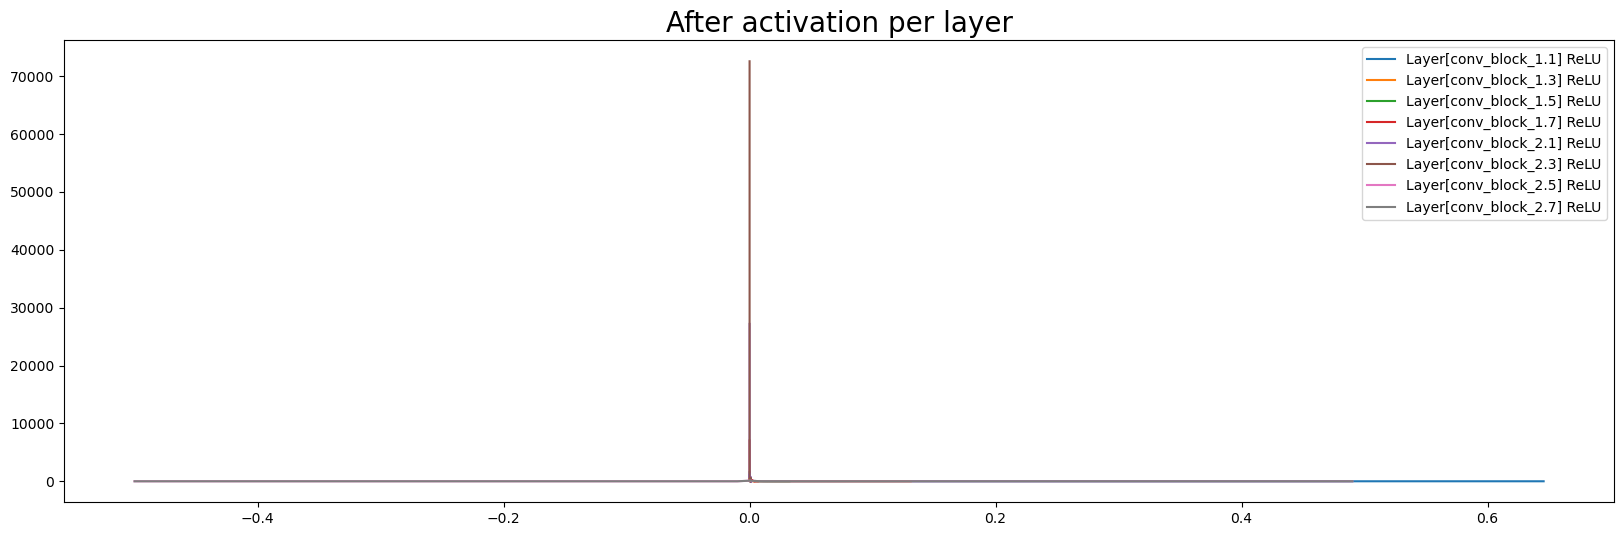

In [51]:
x = torch.randn(1, 1, 28, 28).to(device)
visualize_activations(model, x)

Layer[conv_block_1.1] — mean: 0.01	std: 0.02	saturation: 14.50%
Layer[conv_block_1.3] — mean: 0.00	std: 0.01	saturation: 13.93%
Layer[conv_block_1.5] — mean: 0.00	std: 0.00	saturation: 0.53%
Layer[conv_block_1.7] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.1] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.3] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.5] — mean: 0.00	std: 0.00	saturation: 0.00%
Layer[conv_block_2.7] — mean: 0.00	std: 0.00	saturation: 0.00%


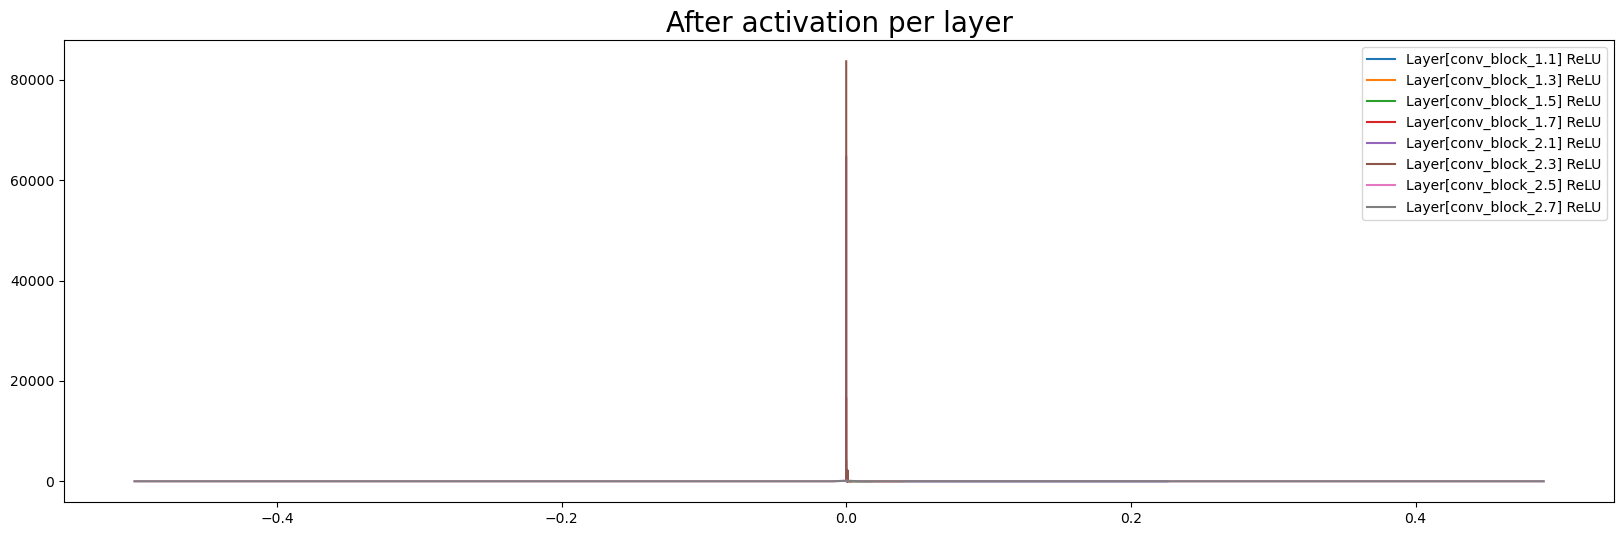

In [52]:
visualize_activations(model, torch.Tensor(X_train[0:8].reshape(-1,1,28,28)).to(device))

## Visualize gradients

In [53]:
def plot_grad_stats(model, X, y, loss_fn):
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    for p in model.parameters():
        if p.grad is not None:
            p.grad.zero_()
    loss.backward()
    
    plt.figure(figsize=(12, 6))
    for name, param in model.named_parameters():
        if param.grad is not None:
            plt.hist(param.grad.cpu().data.numpy().flatten(), bins=100, alpha=0.6, label=name)
    plt.title("Gradient Histogram")
    plt.xlabel("Gradient values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

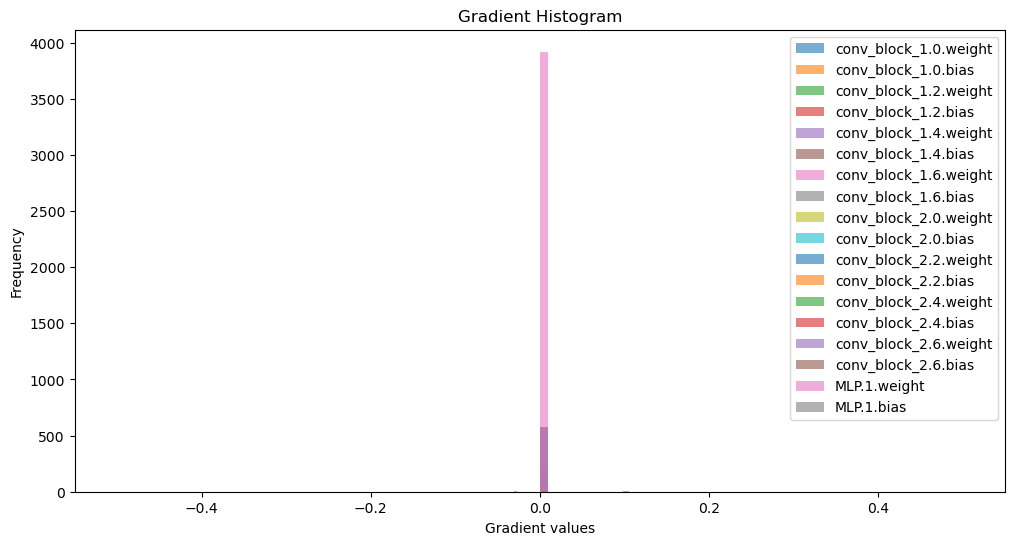

In [54]:
plot_grad_stats(model, torch.Tensor(X_train[0:8].reshape(-1,1,28,28)).to(device), torch.Tensor(y_train[0:8]).to(device), F.cross_entropy)

# Dead neurons/ReLU

The mean in the last convolutional layer after activations is 0 - each input to the ReLU is negative and thus all output is uniformaly 0.
The ReLU unit hence sends back zero gradients to the preceeding layers and they will not get updated.

The reason for this behaviour is the following:
- For a high enough learning rate, it can happen pretty fast that we jump to a point where the ReLU dies.
- After a ReLU is dead it is very hard to awaken it again.

### Possible fixes

- Use a different activation function:
  - `tanh`: Same problem, gradient becomes essentially zero for too low and high values
  - `LeakyReLU`: Negative parts have small gradient
- Better initialization and careful training:
  - add negative bias before ReLU so that it is not all zero
  - carefully supervise training, if dead neurons appear, lower training rate



In [55]:
# Try smaller step size
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.ReLU).to(device)
model.apply(uniform_init)
train(model, lr=0.01)

Before training: validation accuracy: 0.0037
Epoch 0, Loss: 1.3221800327301025, validation accuracy: 0.7419, train accuracy: 0.7484833333333333
Epoch 1, Loss: 0.6289118528366089, validation accuracy: 0.7931, train accuracy: 0.80455
Epoch 2, Loss: 0.5028176307678223, validation accuracy: 0.829, train accuracy: 0.8407833333333333


([tensor(1.3222, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.6289, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.5028, device='mps:0', grad_fn=<AddBackward0>)],
 [0.7419, 0.7931, 0.829],
 [0.7484833333333333, 0.80455, 0.8407833333333333])

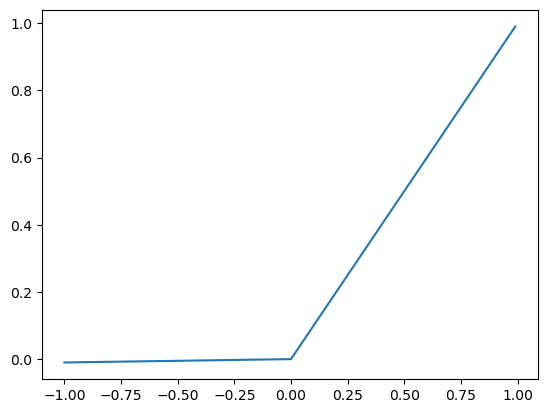

In [56]:
# LeakyReLU
x = np.arange(-1,1,0.01)
y = np.maximum(0.01*x, x)
plt.plot(x, y)

In [58]:
# Try LeakyReLU instead of ReLU
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.LeakyReLU).to(device)
model.apply(uniform_init)
train(model)

Before training: validation accuracy: 0.0461
Epoch 0, Loss: 1.6785098314285278, validation accuracy: 0.8176, train accuracy: 0.82115
Epoch 1, Loss: 0.43315446376800537, validation accuracy: 0.8567, train accuracy: 0.8670833333333333
Epoch 2, Loss: 0.35803788900375366, validation accuracy: 0.8746, train accuracy: 0.88555


([tensor(1.6785, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.4332, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.3580, device='mps:0', grad_fn=<AddBackward0>)],
 [0.8176, 0.8567, 0.8746],
 [0.82115, 0.8670833333333333, 0.88555])

In [59]:
# Will LeakyReLU work with even deeper CNN and smaller learning rate?
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=16, activation=nn.LeakyReLU).to(device)
model.apply(uniform_init)
train(model, lr=0.01)

Before training: validation accuracy: 0.1006
Epoch 0, Loss: 2.3026785850524902, validation accuracy: 0.1, train accuracy: 0.1
Epoch 1, Loss: 2.30271053314209, validation accuracy: 0.1, train accuracy: 0.1
Epoch 2, Loss: 2.3026769161224365, validation accuracy: 0.1, train accuracy: 0.1


([tensor(2.3027, device='mps:0', grad_fn=<AddBackward0>),
  tensor(2.3027, device='mps:0', grad_fn=<AddBackward0>),
  tensor(2.3027, device='mps:0', grad_fn=<AddBackward0>)],
 [0.1, 0.1, 0.1],
 [0.1, 0.1, 0.1])

## Analysis

LeakyReLU and small enough learning rate are helping, but not a general panacea for dying neurons. 

LeakyReLU:
- Still leads to vanishing gradients. Reason is that for negative values gradients are multiplied with 0.001, which exponentially dampens gradients.
Small learning rate:
- If gradient becomes very small at some time, then small learning rate will not help either.

We need a more fundamental solution.


# Initialization

The underlying problem of dead neurons and zero gradients could be corrected if we ensure that the activations at each layer are distributed so that 
- on average they are centered around 0 (where the nonlinearity is)
- values are spread not too far, so that change from linear to zero (and vice-versa) can actually happen.

In other words, mean and variance of activations should be controlled. We will derive initialization schemes below that will assure this to be the case after initialization. We will assume that
- Weights are drawn iid
- zero mean
- and symmetric.
Also
- We take ReLU as non-linearity, but a similar analysis can be performed for tanh and other functions.

To understand what is happening statistically in a neural network, let us take a look simple 9-layer MLP:

![9-layer MLP](9Layer.png)

If we assume non-linearity to be $f$ and the linear layers to be $W_l$, then we can write the input/output relationship as

$$ y = W_{L} \circ f \circ W_{L-1} \circ f \ldots \circ W_{1} x $$

Let us assume that $f$ is the identity and weights have been initialized as

$$ W^i = \begin{pmatrix} 1.5 & 0 \\ 0 & 1.5 \end{pmatrix} $$

When $y = 1.5^L x$ and values $y$ increase exponentially with number of layers.
If

$$ W^i = \begin{pmatrix} 0.5 & 0 \\ 0 & 0.5 \end{pmatrix} $$

then $y = 0.5^L x$ and values $y$ decrease exponentially with number of layers.

- In the first case, values explode and training becomes unstable,
- in the second case, values diminish and training will stall.


## Kaiming initialization

Define

$$ y_l = W_l x_l + b_l $$

be a linear layer (conv or MLP). Also 

$$ x_l = f(y_{l-1}) $$

where $f$ is the non-linear activation (ReLU in our case).

### Forward analysis

We have that 

$$ \text{Var}[y_l] = n_l \text{Var}[w_l x_l] $$

where $n_l is the number of neurons in layer $l$ and $w_l$ is the random variable from which the values in $W_l$ are drawn.
Since we assume $W_l$ and $x_l$ to be independent from each other and $w_l$ to be zero mean, we get

$$ \text{Var}[y_l] = n_l \text{Var}[w_l] \text{E}[x_l^2] $$

since 

$$ \text{Var}[X Y] = \text{Var}[X] \text{Var}[Y] + (\text{E}[X]^2) \text{Var{Y}} + \text{Var{X}} (\text{E}[Y]^2) $$

Since $w_l$ has symmetric distribution we have that

$$ \text{E}[y_l] = 0 $$

and is symmetric. Hence,

$$ \text{E}[x_l^2] = \frac{1}{2} \text{Var}[y_{l-1}] $$

since $f$ is ReLU.
Putting everything together gives

$$ \text{Var}[y_l] = \frac{1}{2} n_l \text{Var}[w_l] \text{Var}[y_{l-1}] $$

Hence, we set

$$ \frac{1}{2} n_l \text{Var}[w_l] = 1 $$

This can be achieved by drawing $w_l \sim \mathcal{N}(0, \sigma = \sqrt{2/n_l})

### Backward analysis

The gradient of a linear layer is computed as

$$ \Delta x_l = W_l^{\top} \Delta y_l $$

where $\Delta \cdot$ is the gradient w.r.t. the loss. We additionally have

$$ \Delta y_{l} = f'(y_l) \Delta x_{l+1} $$

We assume that $f'(y_l)$ and $\Delta x_{l+1}$ are independent of each other.
Then, we have

$$ \text{E}[\Delta y_l] = \frac{1}{2} \text{E}[\Delta x_{l+1}] = 0$$

and also

$$ \text{E}[ (\Delta y_l)^2] = \text{Var}{\Delta y_l} = \frac{1}{2} \text{Var}[\Delta x_{l+1}] $$

Then we compute

$$ \text{Var}[\Delta x_{l}] = n_{l} \text{Var}[w_l] \text{Var}[\Delta y_l] = \frac{1}{2} n_l \text{Var}[w_l] \text{Var}[\Delta x_{l+1}] $$

Hence, we require 

$$ \frac{1}{2} \text{Var}[w_l] = 1 $$

#### Remark on usign `tanh`

A modified analysis can be performed with `tanh` activation, in which case it is known as Xavier initialization.

In [71]:

def uniform_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data.uniform_(-0.1, 0.1)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def kaiming_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        fan_in = m.weight.data.size(1)
        gain = 0.5 # for ReLU
        std = gain / math.sqrt(fan_in)
        m.weight.data.normal_(std = std)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [72]:
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=16, activation=nn.LeakyReLU).to(device)
model.apply(kaiming_init)

DeeperCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): LeakyReLU(negative_slope=0.01)
    (16): Conv2d(4, 4, kernel_size=(3, 3), stride

In [79]:
model(torch.Tensor(torch.randn(1, 1, 28, 28)).to(device))

tensor([[-0.1446,  0.0125, -0.0177,  0.1516,  0.1104,  0.0075,  0.2563,  0.0005,
         -0.0061,  0.1062]], device='mps:0', grad_fn=<LinearBackward0>)

Layer[conv_block_1.1] — mean: 0.51	std: 0.77	saturation: 71.84%
Layer[conv_block_1.3] — mean: 0.11	std: 0.35	saturation: 69.16%
Layer[conv_block_1.5] — mean: 0.14	std: 0.25	saturation: 48.60%
Layer[conv_block_1.7] — mean: 0.20	std: 0.27	saturation: 61.96%
Layer[conv_block_1.9] — mean: 0.10	std: 0.19	saturation: 43.14%
Layer[conv_block_1.11] — mean: 0.17	std: 0.27	saturation: 51.18%
Layer[conv_block_1.13] — mean: 0.13	std: 0.25	saturation: 42.32%
Layer[conv_block_1.15] — mean: 0.12	std: 0.23	saturation: 45.31%
Layer[conv_block_1.17] — mean: 0.09	std: 0.15	saturation: 46.08%
Layer[conv_block_1.19] — mean: 0.08	std: 0.14	saturation: 43.27%
Layer[conv_block_1.21] — mean: 0.10	std: 0.14	saturation: 55.20%
Layer[conv_block_1.23] — mean: 0.05	std: 0.11	saturation: 32.33%
Layer[conv_block_1.25] — mean: 0.08	std: 0.12	saturation: 53.35%
Layer[conv_block_1.27] — mean: 0.20	std: 0.16	saturation: 86.93%
Layer[conv_block_1.29] — mean: 0.13	std: 0.23	saturation: 41.96%
Layer[conv_block_1.31] — mean:

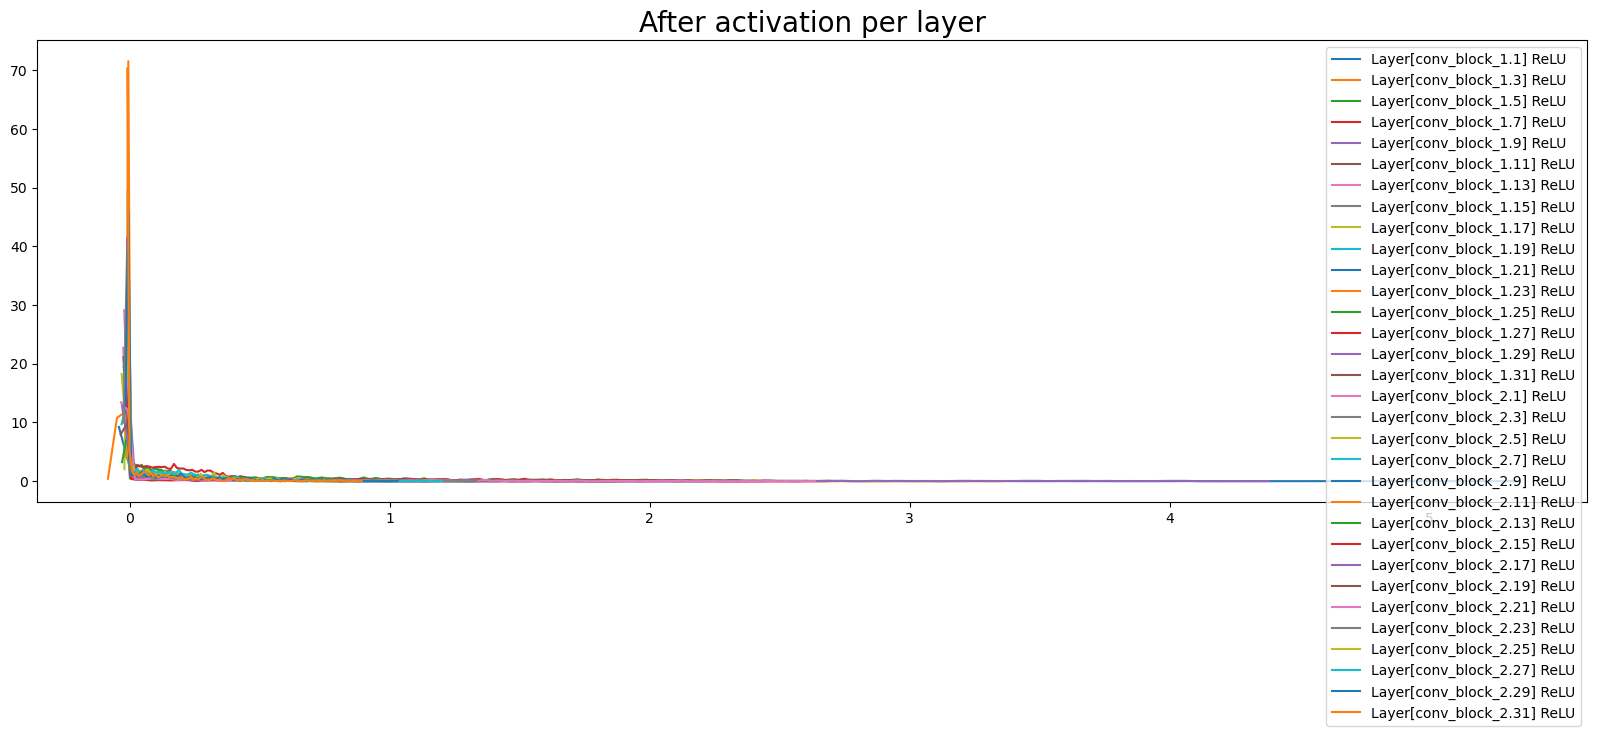

In [80]:
visualize_activations(model, torch.Tensor(torch.randn(1, 1, 28, 28)).to(device))

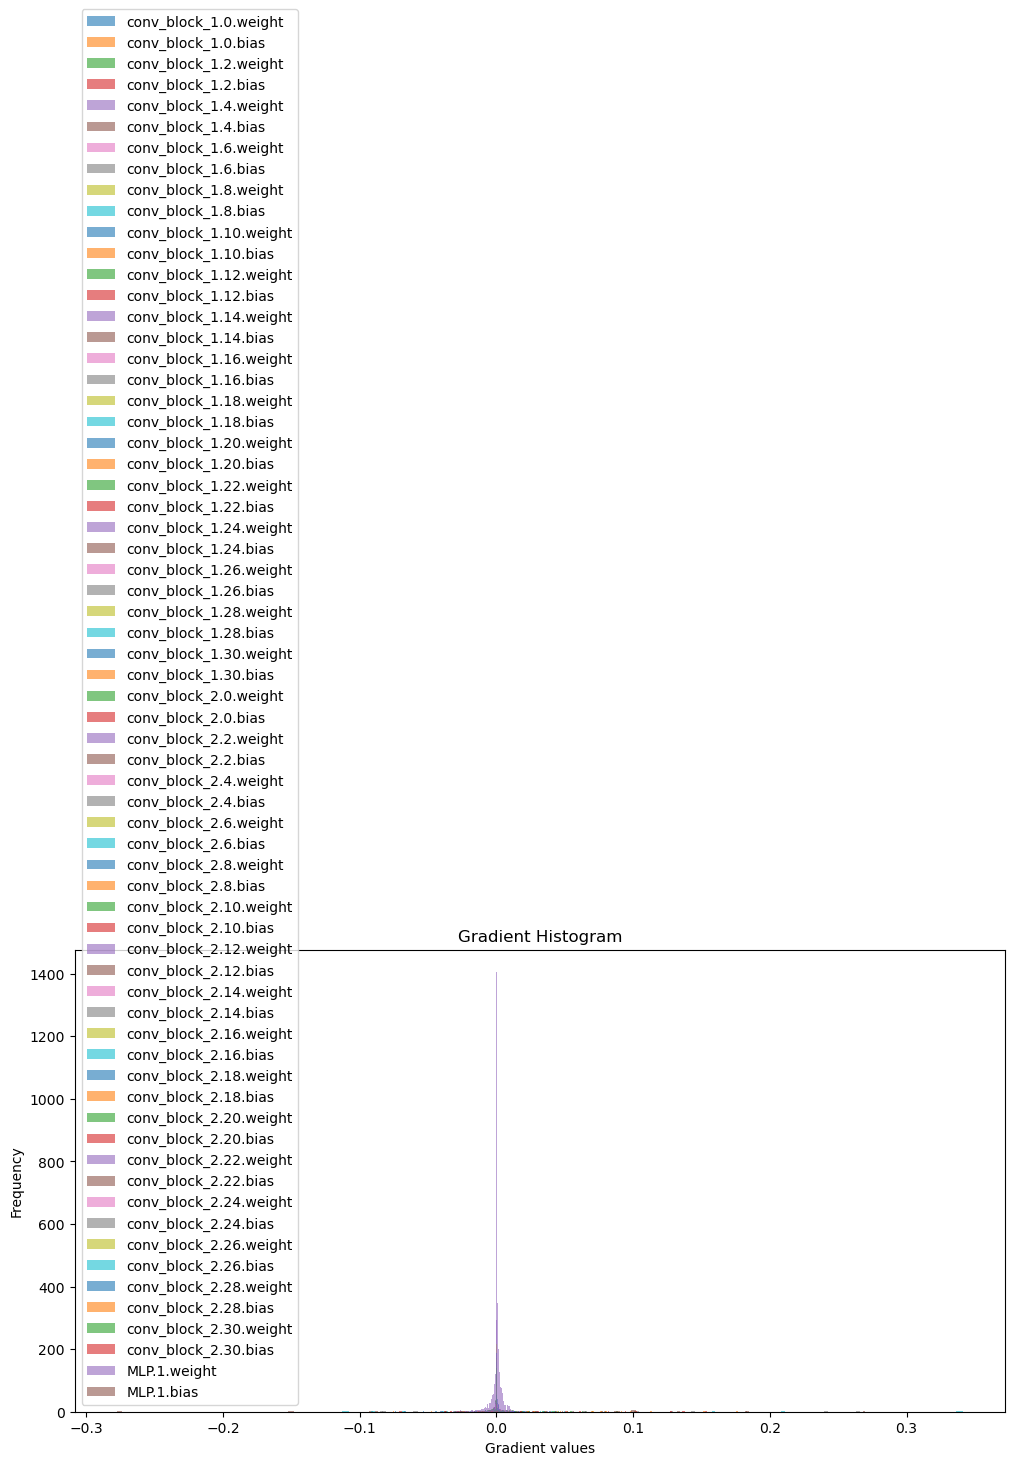

In [74]:
plot_grad_stats(model, torch.Tensor(X_train[0:8].reshape(-1,1,28,28)).to(device), torch.Tensor(y_train[0:8]).to(device), F.cross_entropy)

In [81]:
train(model, lr=0.01, num_epochs=5)

Before training: validation accuracy: 0.1033
Epoch 0, Loss: 0.7972090244293213, validation accuracy: 0.8194, train accuracy: 0.8240166666666666
Epoch 1, Loss: 0.46234336495399475, validation accuracy: 0.8334, train accuracy: 0.8449
Epoch 2, Loss: 0.41146332025527954, validation accuracy: 0.8432, train accuracy: 0.8572833333333333
Epoch 3, Loss: 0.39059460163116455, validation accuracy: 0.8519, train accuracy: 0.8623333333333333
Epoch 4, Loss: 0.37072333693504333, validation accuracy: 0.8568, train accuracy: 0.86825


([tensor(0.7972, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.4623, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.4115, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.3906, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.3707, device='mps:0', grad_fn=<AddBackward0>)],
 [0.8194, 0.8334, 0.8432, 0.8519, 0.8568],
 [0.8240166666666666, 0.8449, 0.8572833333333333, 0.8623333333333333, 0.86825])

## Summary
We could get to train a network that was somewhat deeper using 
- careful learning rate tuning,
- proper initialization and 
- improve gradinet flow by using benign activation functions.
PyTorch by default uses kaiming initialization, so for the rest of the lecture we will not  hand-initialize networks anymore.

Still, situation is not satisfactory. 
- One bad training step could result in many dead neurons. It will be hard to bring them back to life. 
- Initialization only will not enable very deep networks.

# BatchNorm, first try

Kaiming (and Xavier normalization) are
BatchNorm is the Jesus of neural networks: It brings dead neurons back to life.

Idea: Force distribution of incoming values to have mean zero (some values positive and some negative) and variance 1 throughout training, not only during initialization?

In [ ]:
class Whitening2d(nn.Module):
    """
    - Perform normalization
    """
    
    def __init__(self, dim, eps=1e-5):
        """
        `eps`: For avoiding division by zero
        """

        super(Whitening2d, self).__init__()
        
        self.eps = eps
        
    def forward(self, x):   
        xmean = x.mean([0,2,3], keepdims=True)
        xvar = x.var([0,2,3], keepdims=True)
            
        # Normalize
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        return xhat

Integrate BatchNorm into DeeperCNN

In [95]:
class DeeperCNN(nn.Module):
    def __init__(self, c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.ReLU, normalization=Whitening2d):
        super(DeeperCNN, self).__init__()

        self.ops = []
        self.conv_block_1 = [
            nn.Conv2d(in_channels=c_in, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            normalization(hidden_dim_1),
            activation(),
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_1.extend([
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            normalization(hidden_dim_1),
            activation()
            ])
        self.conv_block_1.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.conv_block_1 = nn.Sequential(*self.conv_block_1)

        self.conv_block_2 = [
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            normalization(hidden_dim_2),
            activation()
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_2.extend([
            normalization(hidden_dim_2),
            nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            activation()
            ])
        self.conv_block_2.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.conv_block_2 = nn.Sequential(*self.conv_block_2)

        self.MLP = nn.Sequential(
            nn.Flatten(start_dim=-3, end_dim=-1),
            nn.Linear(in_features=7*7*hidden_dim_2, out_features=c_out),
            # nn.Softmax() -> no softmax, cross entropy loss in pytorch already applies softmax
        )
            
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.MLP(x)
        return x

In [96]:
# Test if BatchNorm2d works
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=16, activation=nn.ReLU,normalization=Whitening2d).to(device)
model(torch.Tensor(X_train[:1,:].reshape(-1,1,28,28)).to(device))

tensor([[-0.0806, -0.5612,  0.2724, -0.0743, -0.2575,  0.3027,  0.0954,  0.4567,
         -0.5803,  0.0281]], device='mps:0', grad_fn=<LinearBackward0>)

Layer[conv_block_1.2] — mean: 0.36	std: 0.56	saturation: 51.29%
Layer[conv_block_1.5] — mean: 0.38	std: 0.54	saturation: 59.52%
Layer[conv_block_1.8] — mean: 0.35	std: 0.51	saturation: 59.43%
Layer[conv_block_1.11] — mean: 0.36	std: 0.60	saturation: 50.98%
Layer[conv_block_1.14] — mean: 0.36	std: 0.68	saturation: 41.89%
Layer[conv_block_1.17] — mean: 0.36	std: 0.57	saturation: 52.33%
Layer[conv_block_1.20] — mean: 0.36	std: 0.61	saturation: 48.69%
Layer[conv_block_1.23] — mean: 0.35	std: 0.63	saturation: 47.64%
Layer[conv_block_1.26] — mean: 0.36	std: 0.69	saturation: 43.79%
Layer[conv_block_1.29] — mean: 0.35	std: 0.62	saturation: 48.62%
Layer[conv_block_1.32] — mean: 0.35	std: 0.58	saturation: 52.40%
Layer[conv_block_1.35] — mean: 0.36	std: 0.60	saturation: 50.17%
Layer[conv_block_1.38] — mean: 0.36	std: 0.60	saturation: 50.07%
Layer[conv_block_1.41] — mean: 0.37	std: 0.52	saturation: 54.97%
Layer[conv_block_1.44] — mean: 0.38	std: 0.61	saturation: 48.78%
Layer[conv_block_1.47] — mea

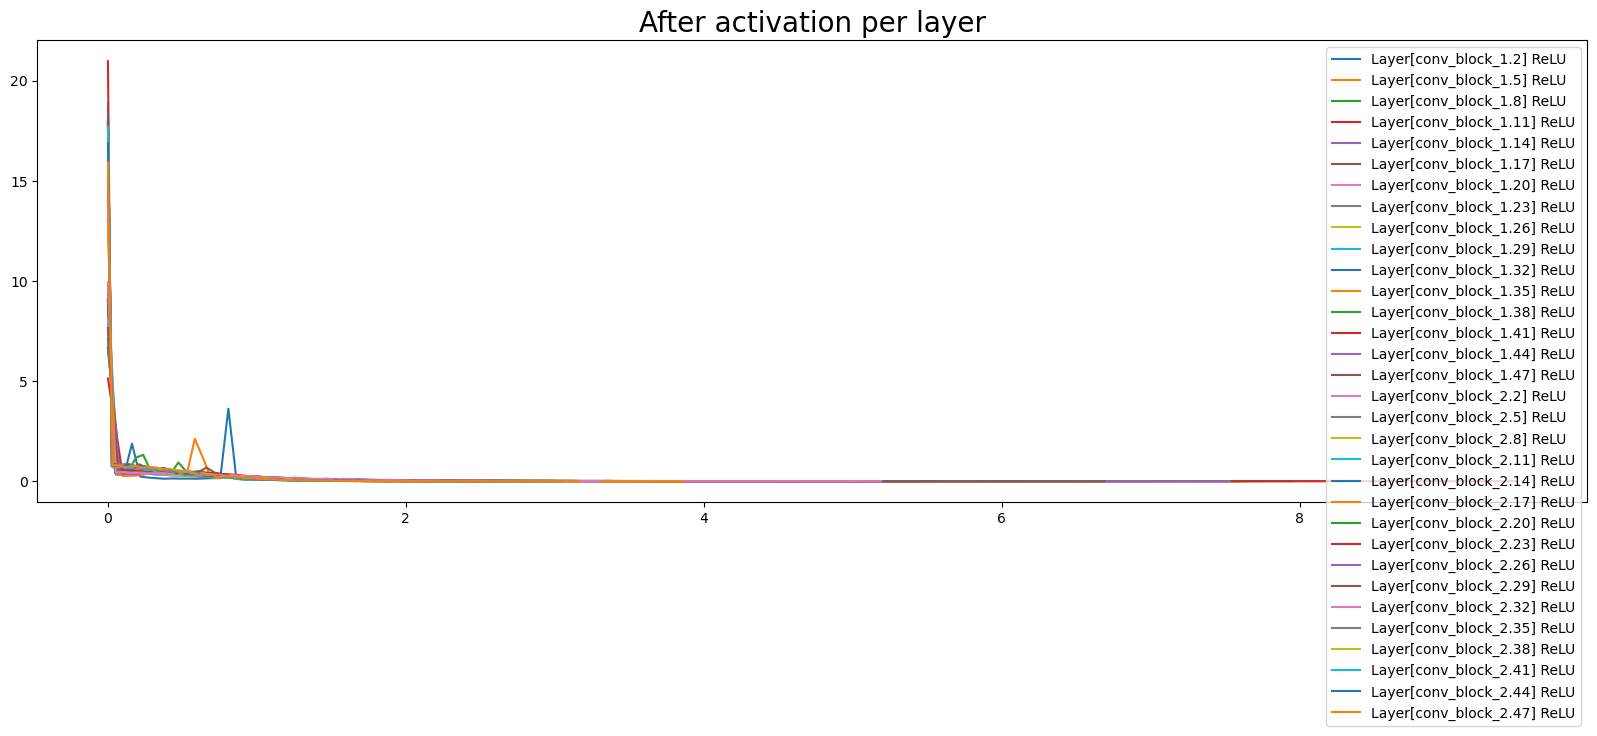

In [97]:
# See activations:
visualize_activations(model, torch.Tensor(X_train[0:8].reshape(-1,1,28,28)).to(device))

In [71]:
train(model, lr=0.01, num_epochs=10)

Before training: validation accuracy: 0.0933
Epoch 0, Loss: 0.7118445038795471, validation accuracy: 0.8045
Epoch 1, Loss: 0.4705725908279419, validation accuracy: 0.8218


KeyboardInterrupt: 

## Discussion

Normalizing before every nonlinearity makes deep learning possible.
However, restricting the distribution to have mean 0 and variance 1 might be too much. Let us learn the best distribution.

### BN forward pass

<img src="BatchNorm.png" alt="Batch Normalization" width="400"/>

### BN training

<img src="BatchNormTraining.png" alt="Batch Normalization" width="400"/>





In [ ]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Learnable parameters: Backprop and update these values during training -> Use nn.Parameter
        self.gamma = nn.Parameter(torch.ones(num_features)).to(device)
        self.beta = nn.Parameter(torch.zeros(num_features)).to(device)

        # Running statistics: We do not update these values during training, but still backprop through them -> Use torch.Tensor
        self.running_mean = torch.zeros(num_features).to(device)
        self.running_var = torch.ones(num_features).to(device)

        self.training = True

    def forward(self, x):
        if self.training:
            # Compute mean and variance for the current batch
            batch_mean = x.mean([0, 2, 3], keepdim=True)
            batch_var = x.var([0, 2, 3], keepdim=True, unbiased=False)

            # Update running statistics
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean.view(-1)
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var.view(-1)

            # Normalize the batch
            x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        else:
            # Use running statistics for normalization during evaluation
            x_hat = (x - self.running_mean.view(1, -1, 1, 1)) / torch.sqrt(self.running_var.view(1, -1, 1, 1) + self.eps)

        # Scale and shift
        out = self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)
        return out

In [76]:
model = DeeperCNN(c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=16, activation=nn.ReLU, normalization=BatchNorm2d).to(device)
train(model, lr=0.01, num_epochs=10)

Before training: validation accuracy: 0.1037
Epoch 0, Loss: 0.6688202619552612, validation accuracy: 0.8035
Epoch 1, Loss: 0.4563279449939728, validation accuracy: 0.8329
Epoch 2, Loss: 0.4136163890361786, validation accuracy: 0.8432


KeyboardInterrupt: 

# Residual connection, ResNet

BatchNorm has allowed us to get better training by **forcing** gradients not to die in the non-linearities.

Another idea of getting gradients through deep networks are **residual** connections.
For this, instead of having a layer be $x \mapsto F(x)$ we instead only parametrize $x \mapsto F(x) + x$. Only the residual $F(x)$ is learned.

Advantages:
- Initialize $F(x)$ to be very small. Initial layers are close to identity and gradient flows through.
- One can think of layers as learning a perturbation of the input data. In ordinary networks one would have to learn identity + perturbation, in residual only the perturbation.
- Very deep (1000 layers) can be learned with ResNets.

## ResNet block

A ResNet block is composed of
- two convolutions,
- batchnorm after every convolution,
- a ReLU in the middle and after the residual connection.
The residual connection connects the input with the output after the second batchnorm

When feature dimensions change, we do not add the identity shortcut but a $1 \times 1$-convolution to account for the feature dimension change.

<div style="background-color: white; display: inline-block;">
<img src="ResNet_block.svg" alt="ResNet block" width="400"/>
</div>

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

## ResNet18 overall architecture

Stack 8 ResNet blocks

<div style="background-color: white; display: inline-block;">
<img src="Resnet-18_architecture.svg.png" alt="ResNet18" width="200"/>
</div>

### Architecture dimensions

<img src="ResNetArchitectures.png" alt="ResNet Architectures" width=500/>

In [17]:
# As originally proposed in the ResNet paper
class ResNet(nn.Module):
    def __init__(self, c_in=1, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(c_in, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64, stride=1),
            ResidualBlock(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512, stride=1)
        )

        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [18]:
# Test ResNet

model = ResNet(c_in=1, num_classes=10).to(device)
x = torch.tensor(np.random.randn(1, 1, 28, 28), dtype=torch.float32).to(device)
print(model(x))

tensor([[-0.0471,  0.7823,  0.1721,  0.0157, -0.3320,  0.4570, -0.6381,  0.1109,
          0.7235,  0.1830]], device='mps:0', grad_fn=<LinearBackward0>)


In [25]:
model = ResNet(c_in=1, num_classes=10).to(device)
train_losses, validation_accs, train_accs = train(model, num_epochs=30, lr=0.001)

Before training: validation accuracy: 0.0896
Epoch 0, Loss: 0.7144209146499634, validation accuracy: 0.8526, train accuracy: 0.8668166666666667
Epoch 1, Loss: 0.35493749380111694, validation accuracy: 0.8828, train accuracy: 0.9068166666666667
Epoch 2, Loss: 0.27973294258117676, validation accuracy: 0.8889, train accuracy: 0.9208166666666666
Epoch 3, Loss: 0.23164944350719452, validation accuracy: 0.8923, train accuracy: 0.9342833333333334
Epoch 4, Loss: 0.19238317012786865, validation accuracy: 0.9011, train accuracy: 0.9521833333333334
Epoch 5, Loss: 0.1580624282360077, validation accuracy: 0.9044, train accuracy: 0.9659666666666666
Epoch 6, Loss: 0.12841203808784485, validation accuracy: 0.9085, train accuracy: 0.97635
Epoch 7, Loss: 0.1028551310300827, validation accuracy: 0.903, train accuracy: 0.9759
Epoch 8, Loss: 0.07964523136615753, validation accuracy: 0.9078, train accuracy: 0.9887
Epoch 9, Loss: 0.06202957406640053, validation accuracy: 0.9097, train accuracy: 0.98978333333

([tensor(0.7144, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.3549, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.2797, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.2316, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.1924, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.1581, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.1284, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.1029, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0796, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0620, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0458, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0356, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0272, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0206, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0154, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0122, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.0100, device='mps:0', grad_fn=<AddBackward0>),
  tensor(0.007